### Plot the correlation between IF signal and tags signal.

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from scipy.stats import linregress, spearmanr, pearsonr
import numpy as np
import math
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                           'ps.fonttype':42})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
path = '../../smomics_data'


# tags

In [4]:
# Load Lambda file
filename = os.path.join(path, 'lambdas_pmeans_spleen_exons_tags_2tags.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

In [5]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)

In [6]:
nwe=[]
nm=lambda_posterior_means.index
for item in nm:
    nwe.append(str(item).split("-")[0])
lambda_posterior_means.index = nwe

# Annotation

In [7]:
annot_list = []

for stdata in [i.split("/")[-1].split("_stdata_adjusted.tsv")[0] for i in np.unique(lambda_posterior_means.columns.get_level_values(0))]:
    
    well = stdata
       
    filename = os.path.join(path, well + '_stdata_adjusted.tsv.annotations.tsv')

    annot_file = pd.read_csv(filename, sep = '\t')
    annot_file = pd.melt(annot_file, id_vars='Unnamed: 0')
    annot_file = annot_file[annot_file['value'] != 0]
    annot_file['image'] = well
    annot_file.drop(['value'], axis=1, inplace=True)
    annot_file.rename(columns = {'Unnamed: 0':'value', 'variable':'x_y'}, inplace=True)

    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)

print(annotdf.head())


         value    x_y         image
3     Red pulp  29_12  10015CN77_C1
4   B follicle  16_30  10015CN77_C1
11    Red pulp  15_15  10015CN77_C1
15    Red pulp   18_8  10015CN77_C1
18        PALS  19_10  10015CN77_C1


In [9]:
# Select gene
collect_merged = {}
pd.set_option('display.max_colwidth', -1)
genes = ['F480', 'IgD',]

collect_genes = {}
for gene in genes:
    # subset all genes
    
    if not gene in lambda_posterior_means.index:
        continue     
    
    lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()
    lambda_gene =  lambda_gene[(lambda_gene[gene] > np.percentile(lambda_gene[gene].values,0.5)) & (lambda_gene[gene] < np.percentile(lambda_gene[gene].values,100))]
    
    # Get name of file, for plotting
    lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]
    
    print(gene)
    collect_genes[gene] = lambda_gene
    
    #collect intensities per gene 
    ab = gene
    samples = list(set(lambda_gene['name'].tolist()))
    ab_list = []
    for well in samples:

        filename = os.path.join(path, well + '_' + ab + '_intensitites.tsv')

        file = pd.read_csv(filename, sep = '\t')

        spot_coord = []

        # if spot coordinates in float...
        if len(list(file)[0].split('.')) == 3:
            for spots in list(file):
                spot_tmp = [ float(elem) for elem in spots.split('_') ]
                spot_tmp2 = [ round(elem, 0) for elem in spot_tmp ]
                spot_tmp3 = [ int(elem) for elem in spot_tmp2 ]

                new_spot_coord = str(spot_tmp3[0]) + '_' + str(spot_tmp3[1])
                spot_coord.append(new_spot_coord)
        else:
            for spots in list(file):
                spots_tmp = spots.split('_')
                new_spot_coord = str(spots_tmp[0]) + '_' + str(spots_tmp[1])   
                spot_coord.append(new_spot_coord)

        file.columns = spot_coord

        filemelt = pd.melt(file)
        filemelt['name'] = well
        filemelt.columns = ['coordinate', ab+".IF", 'name']

        ab_list.append(filemelt)

    abfile = pd.concat(ab_list)

    lambdadfTMP = pd.merge(lambda_gene, abfile,  how='left', on=['name','coordinate'])
    lambdadf = pd.merge(lambdadfTMP, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])
    
    # Only lok at specific regions
    #lambdadf_rm = lambdadf[lambdadf['value'].isin(['Red pulp', 'B follicle', 'PALS', 'Marginal zone'])]

    # Take mean per region per sample

    #trans = lambdadf_rm.groupby(['name', 'value'])[ab, gene].mean()
    trans = lambdadf.groupby(['name', 'value'])[gene+".IF", gene].mean()

    trans.reset_index(inplace=True)

    # Scale min max per sample
    trans[[gene+".IF.norm", gene + '.norm']] = trans.groupby(['name'])[ab+".IF", gene].transform(lambda x: preprocessing.minmax_scale(x))

    collect_merged[gene] = trans

F480
IgD


F480
std err:0.14
Spearman's rho: 0.77
p-value: 0.0037360556186627563
IgD
std err:0.241
Spearman's rho: 0.78
p-value: 0.0029467821871401478


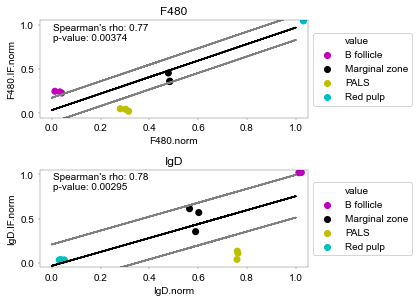

In [10]:
# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(6, 6))
num_cols = 1
axes = []

for i in range(0,int((int(len(genes))/num_cols))):
    for j in range(0, num_cols):
        ax = plt.subplot2grid((int((len(genes))/num_cols+1), num_cols), (i, j))
        axes.append(ax) 
for count, gene in enumerate(collect_merged):

    ax = axes[count]
    plot_trans = collect_merged[gene]
    
    tag = gene
    
    if not tag + '.norm' in plot_trans.columns:
        continue

    plot_trans['jitter_y'] = plot_trans[tag + '.IF.norm'] + 0.05 * np.random.rand(len(plot_trans[tag + '.IF.norm'].tolist())) +0.01
    plot_trans['jitter_x'] = plot_trans[gene + '.norm'] + 0.05 * np.random.rand(len(plot_trans[gene + '.norm'].tolist())) +0.01
    x = 'jitter_x'
    y = 'jitter_y'
    hue = 'value'
    palette = {'Red pulp':'c', 'B follicle':'m', 'PALS':'y', 'Marginal zone':'k', 'White pulp':'r', 'IGDpos':'b'}
    data = plot_trans

    sns.scatterplot(x=x, y=y, data=data, ax=ax, hue=hue, s=50, linewidth=0, palette=palette)

    # X and Y axis
    ax.set_xlabel(gene + '.norm')
    ax.set_ylabel(tag + '.IF.norm')

    # Calculate the linear regression
    X = gene + '.norm'
    Y = tag + '.IF.norm'

    slope, intercept, r_value, p_value, std_err = linregress(data[X], data[Y])

    print(gene)
    print('std err:' + str(round(std_err, 3)))

    coef = np.polyfit(data[X],data[y],1)
    poly1d_fn = np.poly1d(coef)
    ax.plot(data[X], poly1d_fn(data[X]), c="k")
    ax.plot(data[X], poly1d_fn(data[X])+std_err, c="grey")
    ax.plot(data[X], poly1d_fn(data[X])-std_err, c="grey")
    #ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

    # Spearman's & Pearson's r
    spear, ps = spearmanr(data[X], data[Y])
    pear, pp = pearsonr(data[X], data[Y])
    print("Spearman's rho: " + str(round(spear, 2)))
    print("p-value: " + str(ps))

    ax.text(0.05, 0.9, "Spearman's rho: " + str(round(spear, 2)), transform=ax.transAxes, fontsize=10)
    ax.text(0.05, 0.8, "p-value: " + str(round(ps, 5)), transform=ax.transAxes, fontsize=10)
    #ax.get_legend().remove()

    # title
    ax.set_title(gene)

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

# plt.savefig("../../figures/sm_IF_vs_tags.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200, rasterized=True)